In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from params import *
import tqdm
import ghibtools as gh
import seaborn as sns
import pingouin as pg
%matplotlib inline

## TOOLS

APPROCHE PHASE

In [3]:
def encoded_to_usable_df(save=False):
    for patient in patients:
        encoded = pd.read_excel(f'../df_analyse/resp_features_encoded_{patient}.xlsx', index_col = 0)
        spindled = encoded[encoded['spindling code'] == 1].reset_index(drop= True)
        end_cycles = []
        for cycle in range(spindled.shape[0]):
            end_resp = spindled.loc[cycle, 'inspi_time'] + spindled.loc[cycle, 'cycle_duration']
            end_cycles.append(end_resp)
        spindled['end_time'] = end_cycles
        spindled = spindled.drop(columns = ['inspi_index','expi_index','cycle_duration','insp_duration','exp_duration','cycle_freq','insp_volume','exp_volume','total_amplitude','insp_amplitude','exp_amplitude','spindling code'])
        if save:
            spindled.to_excel(f'../df_analyse/spindled_cycles_timings_{patient}.xlsx')

In [4]:
def load_rsp_spindles(patient, stage='N2'):
    spindle_file = f'../df_analyse/spindles_{patient}.xlsx'
    spindles = pd.read_excel(spindle_file).drop(columns = 'Unnamed: 0')
    spindles = spindles[spindles['stage'] == stage]
    spindles_times = spindles['Peak']

    df_cycles = pd.read_excel(f'../df_analyse/spindled_cycles_timings_{patient}.xlsx', index_col = 0)
    return df_cycles, spindles_times

In [5]:
def count_spindles_phase_resp_fast(nbins, patient, spindles_times, df_cycles, stage='N2', return_normal=True):

    count = []

    for cycle in df_cycles.index: # loop only on cycles with spindles found inside
        
        start = df_cycles.loc[cycle,'inspi_time'] # get start time of the cycle
        stop = df_cycles.loc[cycle,'end_time'] # get stop time of the cycle

        phases_timings = np.linspace(start, stop, nbins + 1) # slice the cycle time in n equal phase time points
        
        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values # keep the spindles of the cycle
        
        for spindle_time in spindles_of_the_cycle: # loop on spindles of the cycle
            for phase_bin, phase_start in enumerate(phases_timings): # loop on phases start times and attribute bin value to the phase
                if phase_start == phases_timings[-1]: # trick to stop looping if phase start == last phase timing
                    break 
                else:
                    phase_stop = phases_timings[phase_bin + 1] # stop time of this phase bin = next phase timing after the start phase timing of the list
                    if spindle_time >= phase_start and spindle_time < phase_stop: # if there is a spindle found between start and stop timings of the phase..
                        count.append(phase_bin) # ..the bin value is added to a counter

    if not return_normal: # return raw counts of spindles by bins
        phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
        phase_count = phase_count.to_frame().T
    else: # return normalized counts of spindles by bins (each bin value = bin value / sum of all bin values) = default mode
        phase_count = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
        phase_count = phase_count.to_frame().T
        mi = gh.Modulation_Index(phase_count.values)
        phase_count.insert(0 , 'mi', mi)

    phase_count.insert(0 , 'patient', patient)

    return phase_count

In [6]:
def get_patient_phase_histogram(patient, nbins, stage='N2'):
    df_cycles, spindles_times = load_rsp_spindles(patient, stage)
    count = count_spindles_phase_resp_fast(nbins=nbins, patient=patient, spindles_times=spindles_times, df_cycles=df_cycles, stage=stage)
    count.insert(1 , 'stage' , stage)
    return count

In [7]:
def get_all_patients_phase_histogram(nbins, patients, show=False):
    concat = []
    for patient in patients:
        # print(patient)
        concat.append(get_patient_phase_histogram(patient=patient, nbins=nbins))
    df = pd.concat(concat)

    if show: 
        for patient in patients:
            print(patient)
            gh.Modulation_Index(df.set_index('patient').drop(columns = ['stage','mi']).loc[patient,:].values, show = True)
            plt.show()
            
    return df

In [8]:
def to_tidy(df):
    patients = df['patient'].values
    df = df.set_index('patient')
    rows = []
    for patient in patients:
        stage = df.loc[patient,'stage']
        mi = df.loc[patient,'mi']
        phases = [col for col in df.columns if not col in ['stage','mi']]
        for phase in phases:
            phase_value = df.loc[patient,phase]
            rows.append([patient, stage, mi , phase, phase_value])
    return pd.DataFrame(rows, columns = ['patient','stage','mi','phase','bin value'])
            

## GO

In [9]:
df_2 = get_all_patients_phase_histogram(2, patients)

In [10]:
df_2

,patient,stage,mi,0,1
0,P1,N2,0.003053,0.467485,0.532515
0,P2,N2,0.013197,0.432473,0.567527
0,P3,N2,0.012368,0.434624,0.565376
0,P4,N2,0.000961,0.481752,0.518248
0,P5,N2,0.006456,0.452734,0.547266
0,P6,N2,0.000273,0.490272,0.509728
0,P7,N2,0.001007,0.481322,0.518678
0,P8,N2,0.000041,0.496250,0.503750
0,P9,N2,0.000673,0.484725,0.515275
0,P10,N2,0.005302,0.457158,0.542842


In [11]:
df_2 = to_tidy(df_2)

In [12]:
ttest = pg.ttest(x= df_2[df_2['phase']==1]['bin value'] , y=0.5)

In [13]:
ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.460383,9,two-sided,0.001576,"[0.52, 0.55]",1.410497,27.991,0.976612


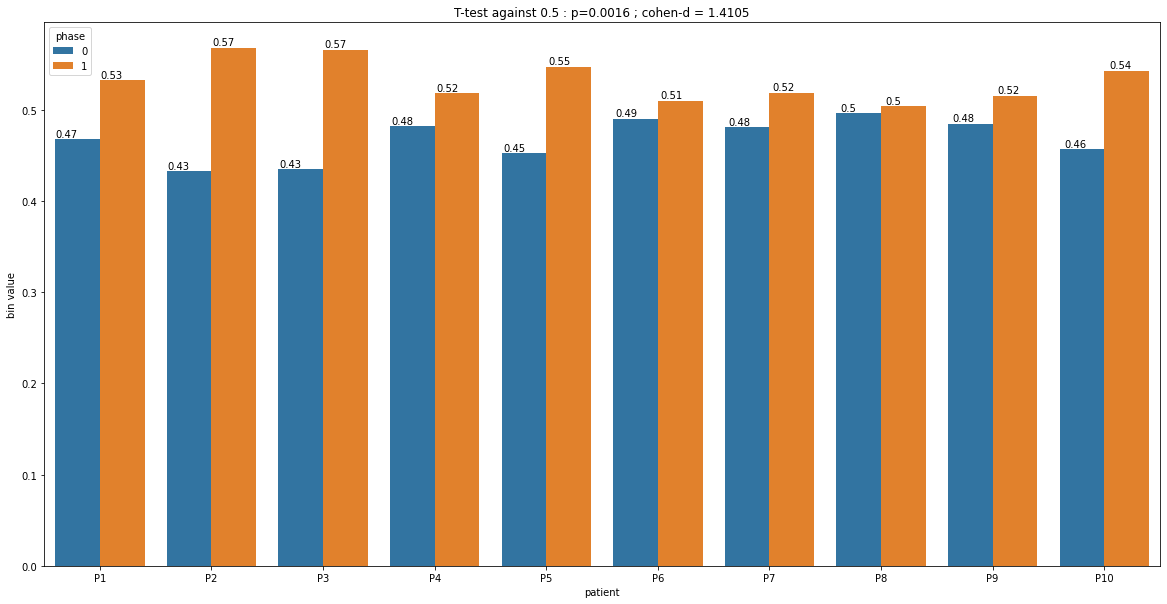

In [14]:
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(data =df_2, x='patient', y ='bin value', hue = 'phase', ax=ax)
p = ttest.loc['T-test', 'p-val'].round(4)
cohen = ttest.loc['T-test', 'cohen-d'].round(4)
ax.set_title(f'T-test against 0.5 : p={p} ; cohen-d = {cohen}')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
# plt.savefig('../presentation_2/bar_2_bins')

In [15]:
df_18 = get_all_patients_phase_histogram(18, patients)
df_18

,patient,stage,mi,0,1,2,3,4,5,6,...,8,9,10,11,12,13,14,15,16,17
0,P1,N2,0.002354,0.058663,0.048204,0.059573,0.046839,0.055480,0.045475,0.053206,...,0.053206,0.055025,0.058663,0.059118,0.055935,0.055935,0.074579,0.059573,0.060482,0.053206
0,P2,N2,0.005643,0.048558,0.039833,0.048179,0.049317,0.053111,0.048938,0.049697,...,0.051214,0.073596,0.075493,0.059181,0.072838,0.053869,0.066388,0.055008,0.061836,0.049317
0,P3,N2,0.005904,0.054557,0.048766,0.034136,0.039012,0.045413,0.045108,0.054252,...,0.056690,0.053337,0.058824,0.074672,0.067358,0.068881,0.059433,0.060957,0.065529,0.056385
0,P4,N2,0.002306,0.052717,0.049878,0.056772,0.059205,0.058800,0.046634,0.058394,...,0.048256,0.050689,0.065288,0.068532,0.056772,0.062449,0.062449,0.051906,0.044607,0.055556
0,P5,N2,0.004595,0.034760,0.059771,0.053836,0.051717,0.056380,0.043663,0.043663,...,0.053412,0.053836,0.056380,0.065282,0.061891,0.062315,0.065706,0.075032,0.055108,0.051717
0,P6,N2,0.003744,0.052529,0.046693,0.046693,0.060311,0.065175,0.061284,0.062257,...,0.048638,0.059339,0.067121,0.050584,0.044747,0.056420,0.048638,0.063230,0.047665,0.071984
0,P7,N2,0.002056,0.054815,0.067956,0.058945,0.055378,0.054252,0.052938,0.047494,...,0.046931,0.053126,0.053876,0.055754,0.055378,0.055566,0.060822,0.056505,0.063826,0.063826
0,P8,N2,0.008726,0.061250,0.075000,0.053750,0.047500,0.041250,0.060000,0.077500,...,0.042500,0.055000,0.062500,0.080000,0.042500,0.063750,0.047500,0.061250,0.046250,0.045000
0,P9,N2,0.004217,0.061100,0.059063,0.041752,0.058045,0.059063,0.061100,0.052953,...,0.045825,0.058045,0.067210,0.075356,0.053971,0.046843,0.042770,0.052953,0.065173,0.052953
0,P10,N2,0.005346,0.060671,0.062267,0.057477,0.060138,0.048430,0.052155,0.035657,...,0.043108,0.050027,0.055349,0.060671,0.050027,0.063332,0.063864,0.067057,0.068121,0.064396


P1


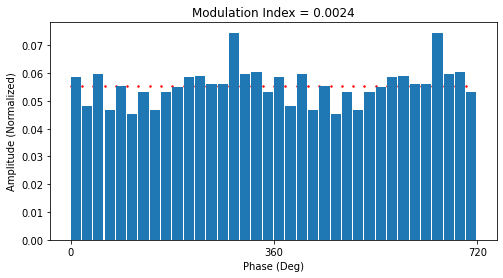

P2


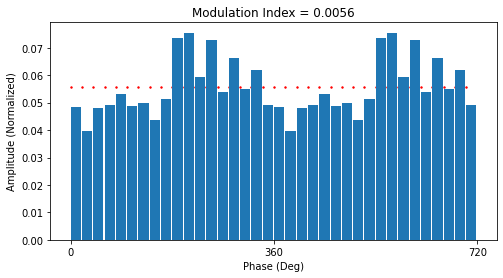

P3


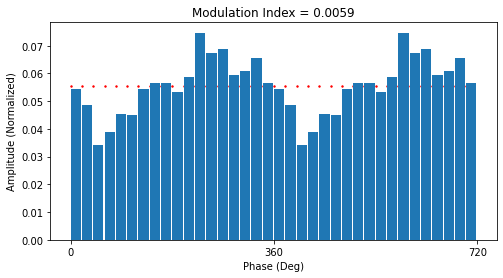

P4


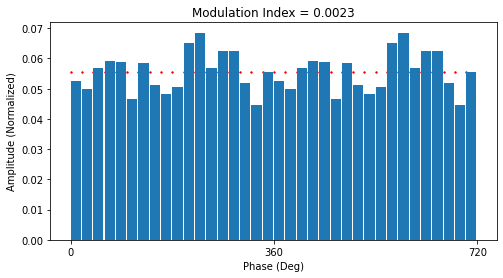

P5


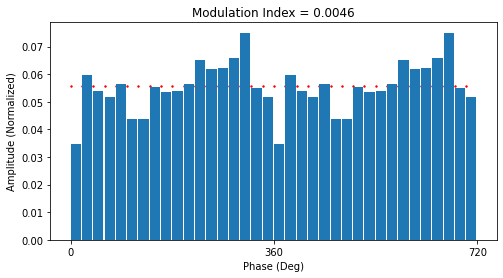

P6


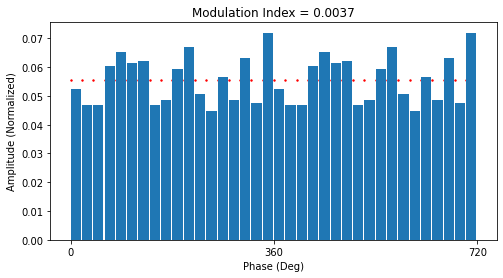

P7


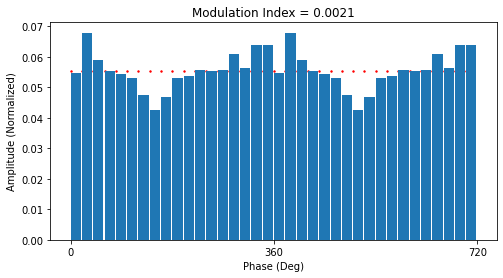

P8


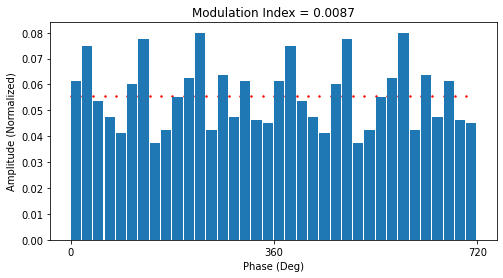

P9


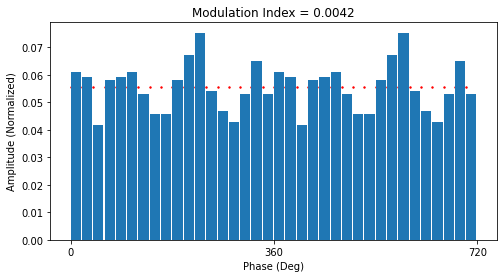

P10


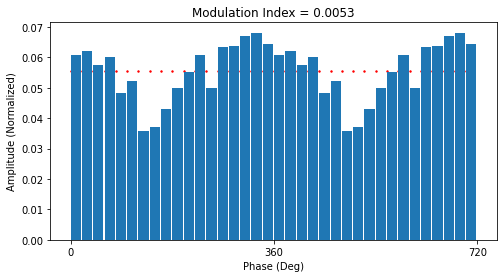

In [16]:
df_all = get_all_patients_phase_histogram(18, patients, show = True)

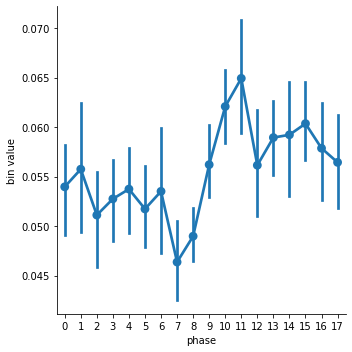

In [17]:
sns.catplot(data=to_tidy(df_all), x='phase', y = 'bin value', kind ='point')

APPROCHE TIME

In [18]:
df_cycles, spindles_times = load_rsp_spindles('P7')

In [19]:
df_cycles

,patient,inspi_time,expi_time,end_time
0,P7,3.769531,5.218750,7.003906
1,P7,7.003906,8.531250,10.449219
2,P7,21.257812,22.683594,24.878906
3,P7,24.878906,26.312500,28.460938
4,P7,28.460938,29.984375,32.343750
...,...,...,...,...
1435,P7,9221.273438,9222.589844,9224.816406
1436,P7,9224.816406,9226.128906,9228.046875
1437,P7,9231.464844,9232.902344,9235.164062
1438,P7,9235.164062,9236.621094,9239.171875


In [20]:
spindles_times

71         5.097656
72        53.078125
73        95.632812
74       107.941406
75       119.960938
           ...     
5454    9341.800781
5455    9394.507812
5456    9512.816406
5457    9555.250000
5458    9607.140625
Name: Peak, Length: 5388, dtype: float64

In [21]:
def get_timestamps(df_cycles, spindles_times, patient):
    rows = []

    for cycle in df_cycles.index: # loop only on cycles with spindles found inside

        start = df_cycles.loc[cycle,'inspi_time'] # get start time of the cycle
        transition = df_cycles.loc[cycle,'expi_time'] # get i-e time of the cycle
        stop = df_cycles.loc[cycle,'end_time'] # get stop time of the cycle
        duration = stop - start
        inspi_duration = transition - start
        expi_duration = stop - transition

        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values # keep the spindles of the cycle

        for spindle_time in spindles_of_the_cycle: # loop on spindles of the cycle
            time_post_start = spindle_time - start
            time_vs_transition = spindle_time - transition
            time_pre_end = stop - spindle_time

            norm_time = (spindle_time - start) / duration

            rows.append([patient, cycle, start, transition, stop, inspi_duration, expi_duration, duration, spindle_time, time_post_start, time_vs_transition, time_pre_end, norm_time])
    df_times = pd.DataFrame(rows, columns = ['patient','cycle','start cycle', 'transition ie', 'stop cycle', 'inspi duration','expi duration','cycle duration','spindle time', 'time post start', 'time vs transition ie','time pre end','norm time'])
    return df_times

In [22]:
concat_df_times = []

for patient in patients:
    df_cycles, spindles_times = load_rsp_spindles(patient)
    concat_df_times.append(get_timestamps(df_cycles, spindles_times, patient))
    
df_times_all = pd.concat(concat_df_times)

In [23]:
df_times_all

,patient,cycle,start cycle,transition ie,stop cycle,inspi duration,expi duration,cycle duration,spindle time,time post start,time vs transition ie,time pre end,norm time
0,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.878906,1.562500,0.472656,1.082031,0.590842
1,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.507812,1.191406,0.101562,1.453125,0.450517
2,P1,1,27.113281,28.269531,30.230469,1.156250,1.960938,3.117188,29.421875,2.308594,1.152344,0.808594,0.740602
3,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.152344,1.921875,0.863281,1.082031,0.639792
4,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.066406,1.835938,0.777344,1.167969,0.611183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.191406,3.253906,2.035156,0.027344,0.991667
1878,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1879,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1880,P10,754,7072.054688,7073.234375,7075.253906,1.179688,2.019531,3.199219,7072.378906,0.324219,-0.855469,2.875000,0.101343


<AxesSubplot:ylabel='Frequency'>

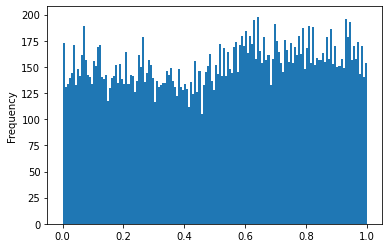

In [24]:
df_times_all['norm time'].plot.hist(bins=150)

<AxesSubplot:ylabel='Frequency'>

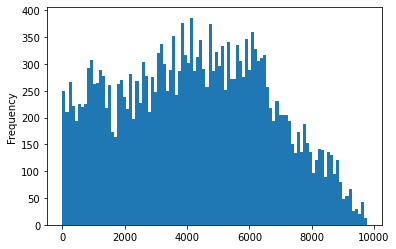

In [25]:
df_times_all['spindle time'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

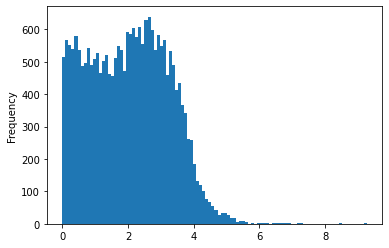

In [26]:
df_times_all['time post start'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

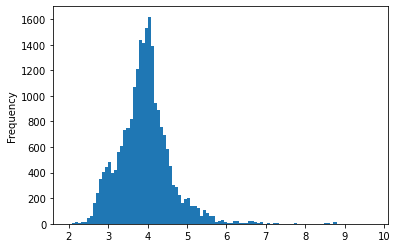

In [27]:
df_times_all['cycle duration'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

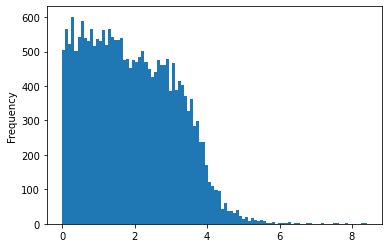

In [28]:
df_times_all['time pre end'].plot.hist(bins = 100)

In [29]:
df_times_all

,patient,cycle,start cycle,transition ie,stop cycle,inspi duration,expi duration,cycle duration,spindle time,time post start,time vs transition ie,time pre end,norm time
0,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.878906,1.562500,0.472656,1.082031,0.590842
1,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.507812,1.191406,0.101562,1.453125,0.450517
2,P1,1,27.113281,28.269531,30.230469,1.156250,1.960938,3.117188,29.421875,2.308594,1.152344,0.808594,0.740602
3,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.152344,1.921875,0.863281,1.082031,0.639792
4,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.066406,1.835938,0.777344,1.167969,0.611183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.191406,3.253906,2.035156,0.027344,0.991667
1878,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1879,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1880,P10,754,7072.054688,7073.234375,7075.253906,1.179688,2.019531,3.199219,7072.378906,0.324219,-0.855469,2.875000,0.101343


In [30]:
df_times_all.mean()

/tmp/ipykernel_2528901/3433375342.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_times_all.mean()


cycle                     469.195135
start cycle              4245.863505
transition ie            4247.280482
stop cycle               4249.797100
inspi duration              1.416977
expi duration               2.516618
cycle duration              3.933595
spindle time             4247.892505
time post start             2.029000
time vs transition ie       0.612023
time pre end                1.904594
norm time                   0.516061
dtype: float64

<AxesSubplot:>

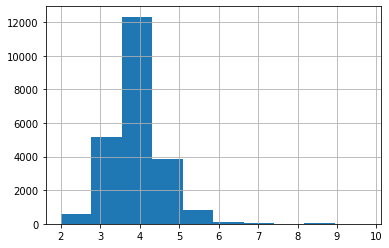

In [31]:
df_times_all['cycle duration'].hist()

<AxesSubplot:>

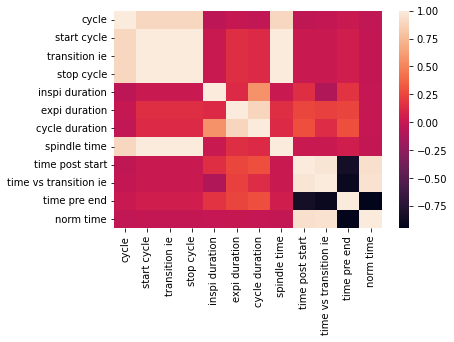

In [32]:
sns.heatmap(df_times_all.corr())

In [33]:
df_times_all

,patient,cycle,start cycle,transition ie,stop cycle,inspi duration,expi duration,cycle duration,spindle time,time post start,time vs transition ie,time pre end,norm time
0,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.878906,1.562500,0.472656,1.082031,0.590842
1,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.507812,1.191406,0.101562,1.453125,0.450517
2,P1,1,27.113281,28.269531,30.230469,1.156250,1.960938,3.117188,29.421875,2.308594,1.152344,0.808594,0.740602
3,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.152344,1.921875,0.863281,1.082031,0.639792
4,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.066406,1.835938,0.777344,1.167969,0.611183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.191406,3.253906,2.035156,0.027344,0.991667
1878,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1879,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1880,P10,754,7072.054688,7073.234375,7075.253906,1.179688,2.019531,3.199219,7072.378906,0.324219,-0.855469,2.875000,0.101343


In [34]:
df_times_all.mean()

/tmp/ipykernel_2528901/3433375342.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_times_all.mean()


cycle                     469.195135
start cycle              4245.863505
transition ie            4247.280482
stop cycle               4249.797100
inspi duration              1.416977
expi duration               2.516618
cycle duration              3.933595
spindle time             4247.892505
time post start             2.029000
time vs transition ie       0.612023
time pre end                1.904594
norm time                   0.516061
dtype: float64

In [35]:
df_times_all

,patient,cycle,start cycle,transition ie,stop cycle,inspi duration,expi duration,cycle duration,spindle time,time post start,time vs transition ie,time pre end,norm time
0,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.878906,1.562500,0.472656,1.082031,0.590842
1,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.507812,1.191406,0.101562,1.453125,0.450517
2,P1,1,27.113281,28.269531,30.230469,1.156250,1.960938,3.117188,29.421875,2.308594,1.152344,0.808594,0.740602
3,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.152344,1.921875,0.863281,1.082031,0.639792
4,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.066406,1.835938,0.777344,1.167969,0.611183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.191406,3.253906,2.035156,0.027344,0.991667
1878,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1879,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1880,P10,754,7072.054688,7073.234375,7075.253906,1.179688,2.019531,3.199219,7072.378906,0.324219,-0.855469,2.875000,0.101343


In [36]:
# sns.kdeplot(x=df_times_all['cycle duration']), y = df_times_all['time post start'], thresh = 0.8, levels = 5)

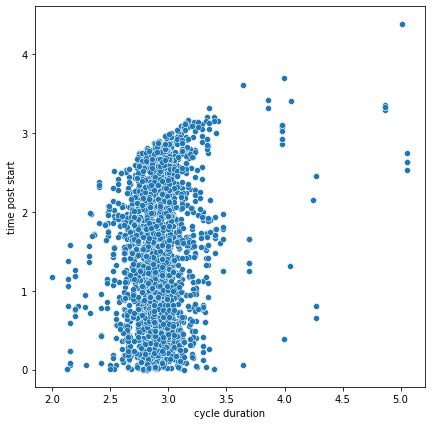

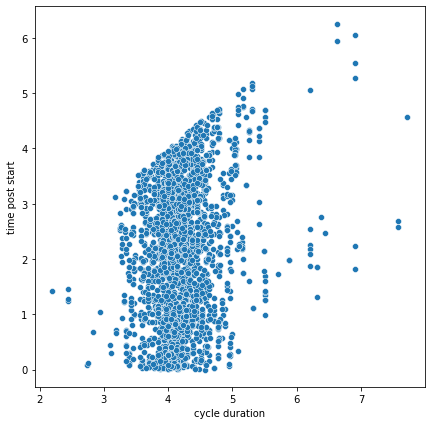

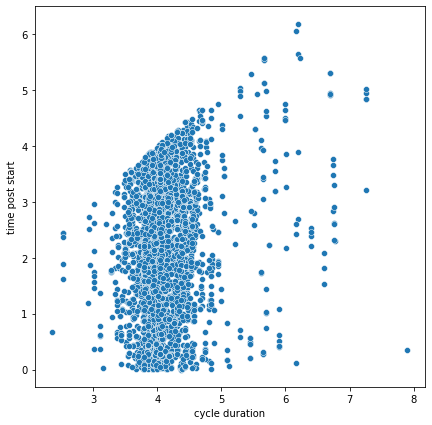

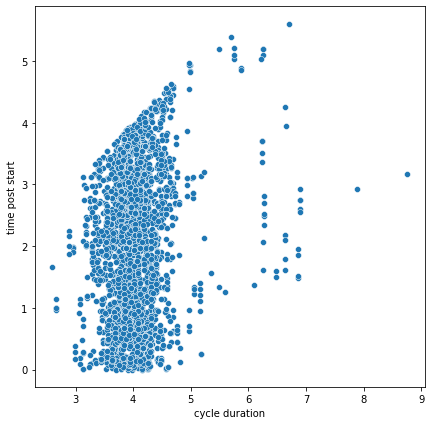

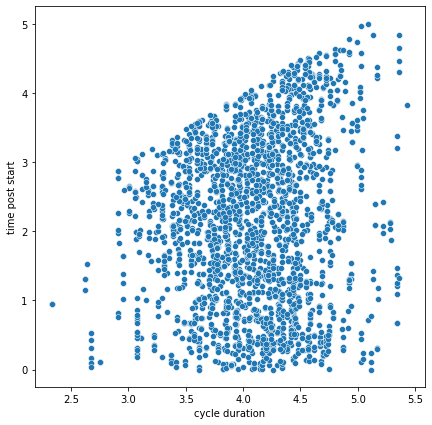

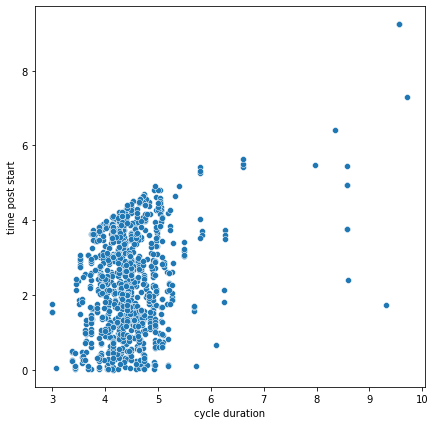

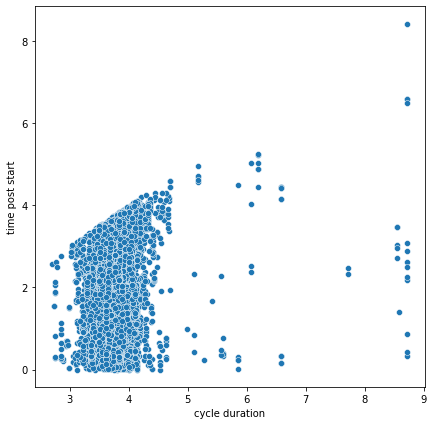

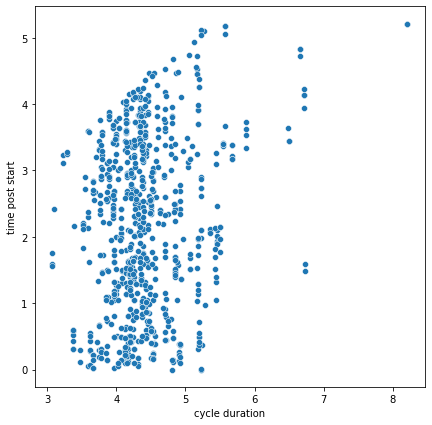

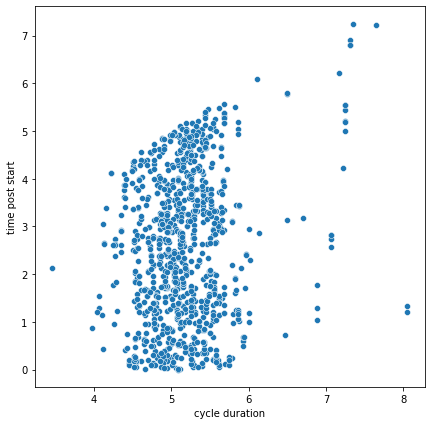

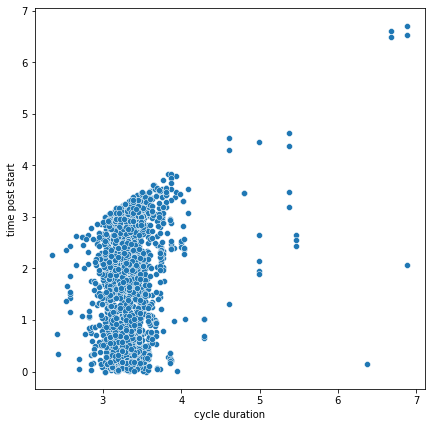

In [37]:
for patient in patients:
    plt.figure(figsize = (7,7))
    x = 'cycle duration'
    y = 'time post start'
    sns.scatterplot(x=df_times_all[df_times_all['patient'] == patient][x],y= df_times_all[df_times_all['patient'] == patient][y])
    plt.xlabel(x)
    plt.ylabel(y)
    # plt.xlim(0,10)
    # plt.ylim(0,10)
    plt.show()

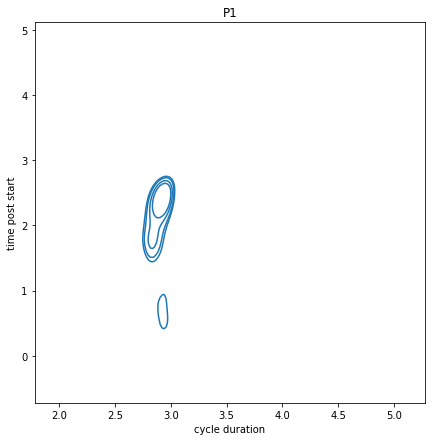

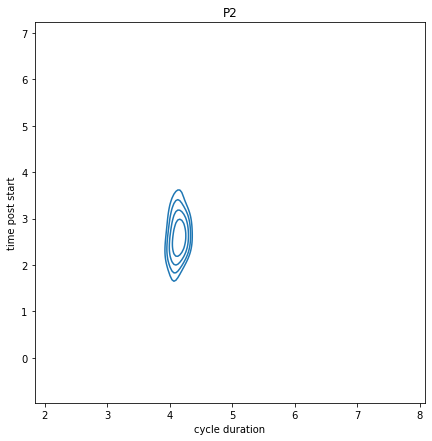

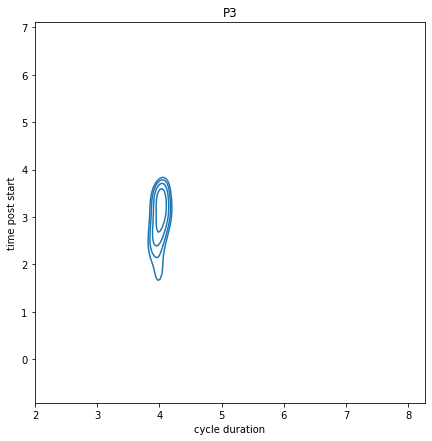

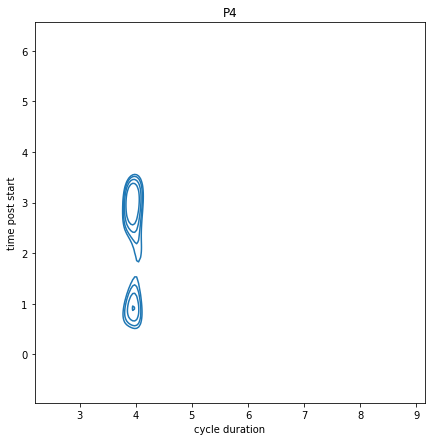

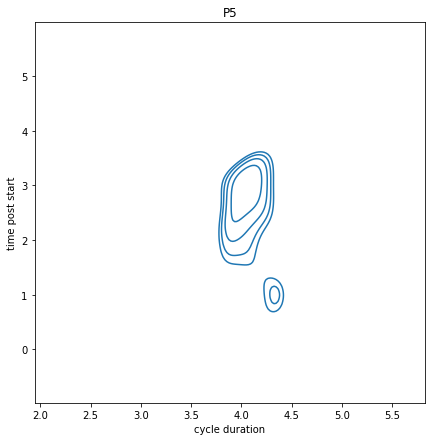

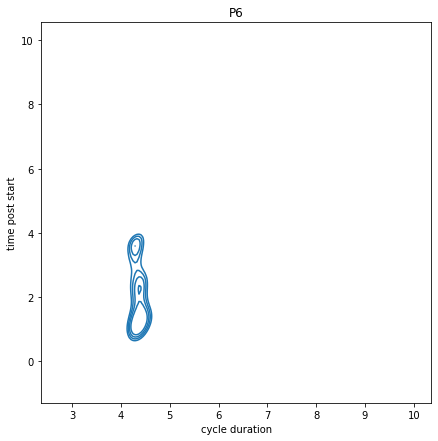

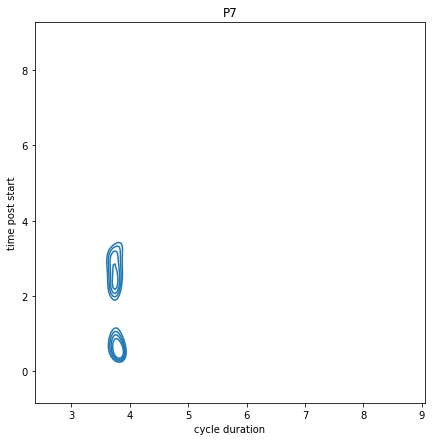

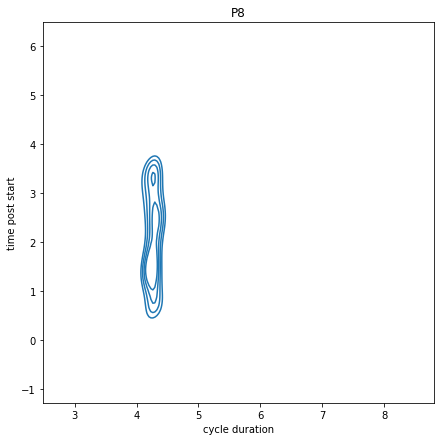

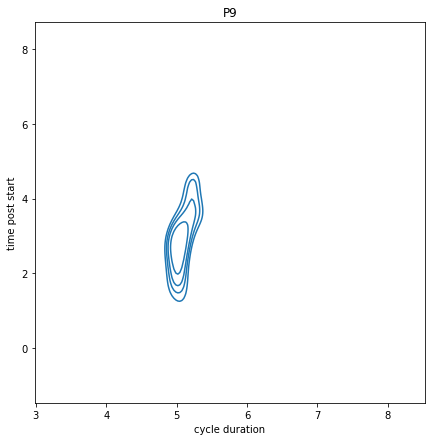

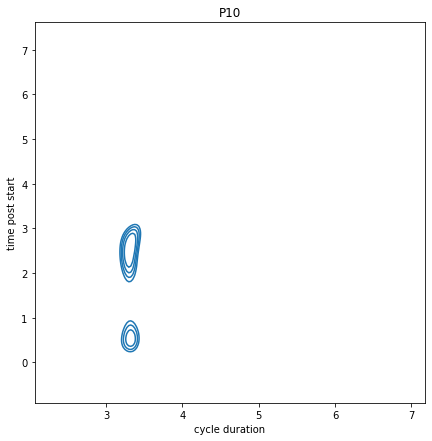

In [38]:
for patient in patients:
    plt.figure(figsize = (7,7))
    x = 'cycle duration'
    y = 'time post start'
    sns.kdeplot(x=df_times_all[df_times_all['patient'] == patient][x],y= df_times_all[df_times_all['patient'] == patient][y], thresh = 0.8, levels = 5)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(patient)
    # plt.xlim(0,10)
    # plt.ylim(0,10)
    plt.show()

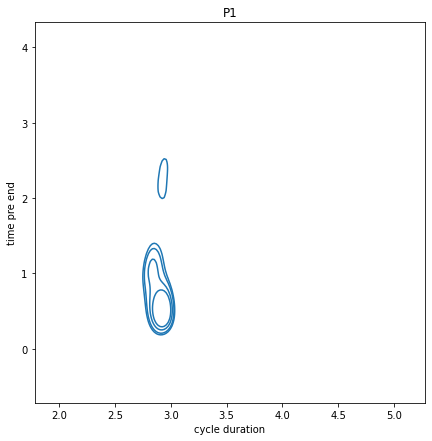

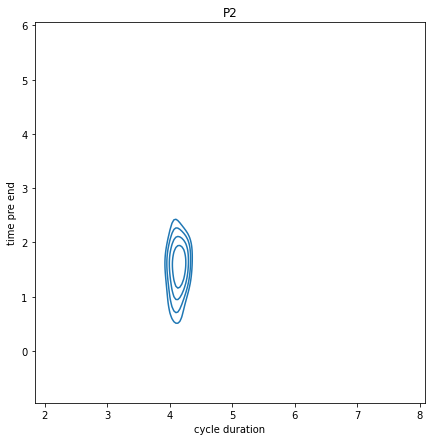

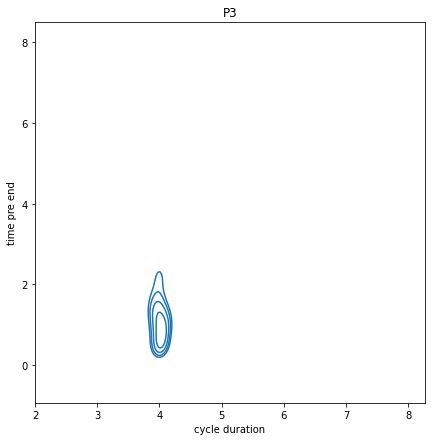

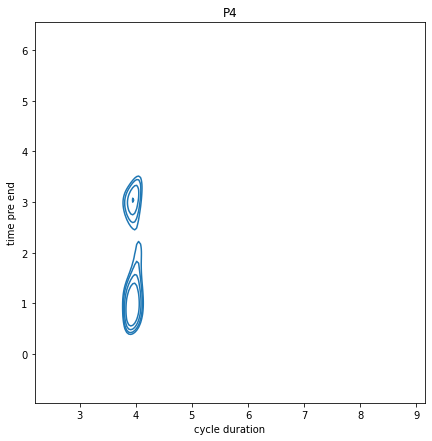

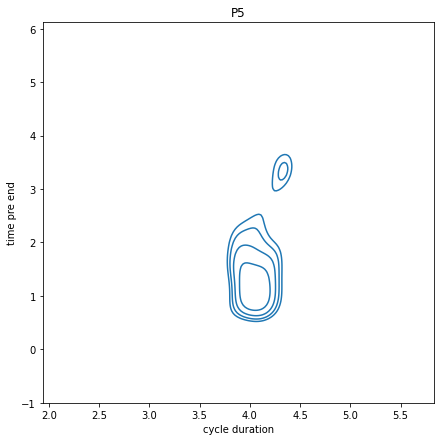

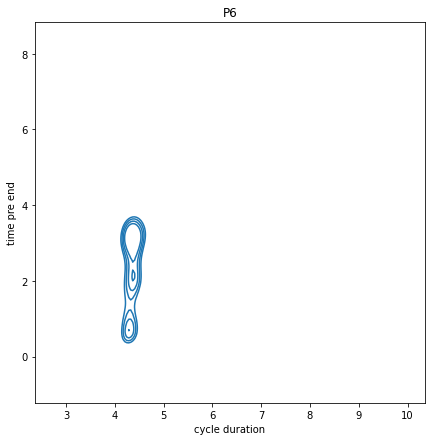

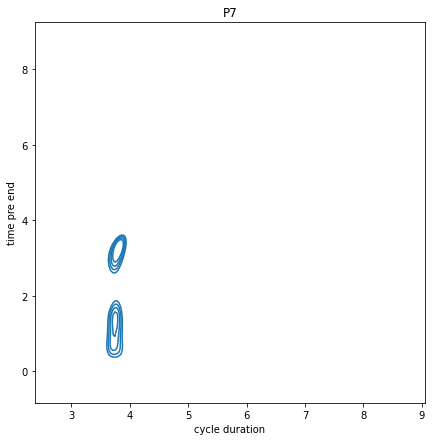

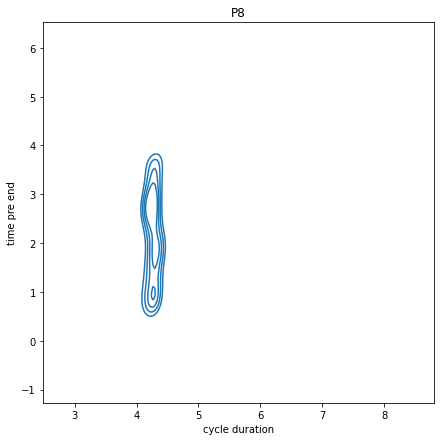

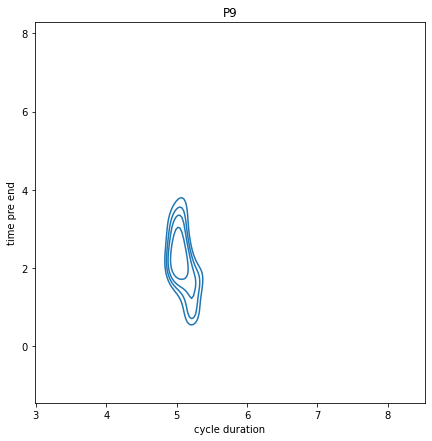

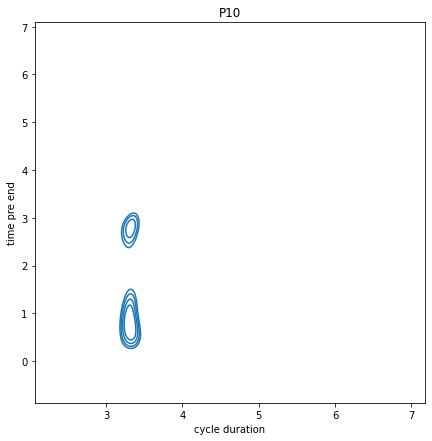

In [39]:
for patient in patients:
    plt.figure(figsize = (7,7))
    x = 'cycle duration'
    y = 'time pre end'
    sns.kdeplot(x=df_times_all[df_times_all['patient'] == patient][x],y= df_times_all[df_times_all['patient'] == patient][y], thresh = 0.8, levels = 5)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(patient)
    # plt.xlim(0,10)
    # plt.ylim(0,10)
    plt.show()

In [40]:
df_times_all

,patient,cycle,start cycle,transition ie,stop cycle,inspi duration,expi duration,cycle duration,spindle time,time post start,time vs transition ie,time pre end,norm time
0,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.878906,1.562500,0.472656,1.082031,0.590842
1,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.507812,1.191406,0.101562,1.453125,0.450517
2,P1,1,27.113281,28.269531,30.230469,1.156250,1.960938,3.117188,29.421875,2.308594,1.152344,0.808594,0.740602
3,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.152344,1.921875,0.863281,1.082031,0.639792
4,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.066406,1.835938,0.777344,1.167969,0.611183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.191406,3.253906,2.035156,0.027344,0.991667
1878,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1879,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1880,P10,754,7072.054688,7073.234375,7075.253906,1.179688,2.019531,3.199219,7072.378906,0.324219,-0.855469,2.875000,0.101343


In [41]:
test = df_times_all[(df_times_all['patient'] == 'P1') & (df_times_all['cycle'] == 10)]
test

,patient,cycle,start cycle,transition ie,stop cycle,inspi duration,expi duration,cycle duration,spindle time,time post start,time vs transition ie,time pre end,norm time
20,P1,10,66.882812,68.0,70.285156,1.117188,2.285156,3.402344,68.660156,1.777344,0.660156,1.625000,0.522388
21,P1,10,66.882812,68.0,70.285156,1.117188,2.285156,3.402344,68.824219,1.941406,0.824219,1.460938,0.570608
22,P1,10,66.882812,68.0,70.285156,1.117188,2.285156,3.402344,68.656250,1.773438,0.656250,1.628906,0.521240


In [83]:
df_times_all.sort_values(by = 'cycle duration')

array([  37,  303,  322, ..., 1087, 1125, 1119])

In [137]:
def get_event_plot_patient(df, patient, ax=None, colname = 'norm time'):
    df_patient =  df[(df['patient'] == patient)][['cycle',colname,'cycle duration']].sort_values(by = 'cycle duration')
    rows = []
    for c in df_patient['cycle'].unique():
        row = df_patient[df_patient['cycle'] == c]
        rows.append(list(row[colname].values) )
        
    if ax is None:
        fig, ax = plt.subplots()
    ax.eventplot(rows,linelengths=10, linewidth = 2, colors = 'black')
    return ax

In [138]:
def lists_to_np_zero_padded(my_list):
    a_list = my_list

    row_lengths = []

    for row in a_list:
        row_lengths.append(len(row))

    max_length = max(row_lengths)

    for row in a_list:
        while len(row) < max_length:
            row.append(0)

    balanced_array = np.array(a_list)
    return balanced_array

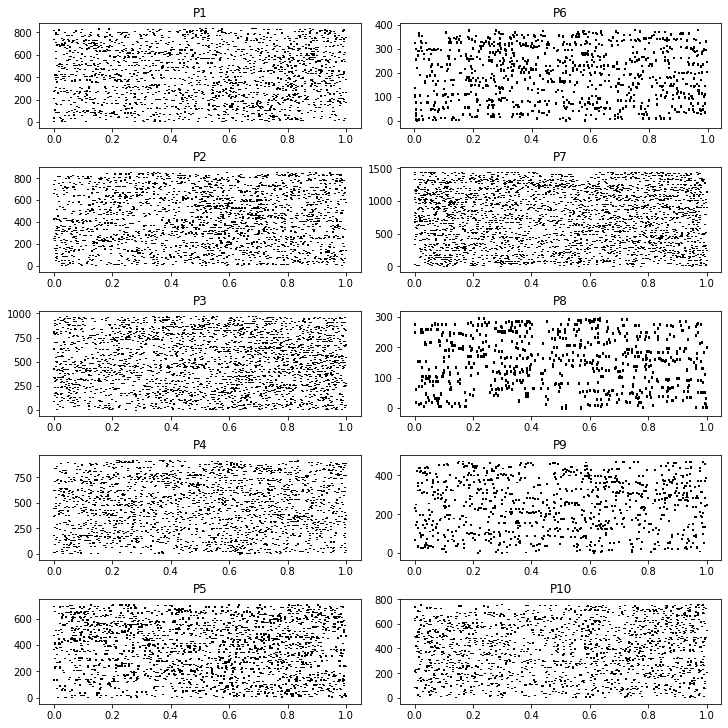

In [139]:
fig, axs = plt.subplots(ncols = 2, nrows = 5, figsize = (10,10), constrained_layout = True)
for col, semi_list in enumerate([patients[:5],patients[5:]]):
    for row, patient in enumerate(semi_list):
        ax = axs[row, col]
        ax = get_event_plot_patient(df=df_times_all, patient=patient, ax=ax, colname = 'norm time')
        ax.set_title(patient)
plt.show()

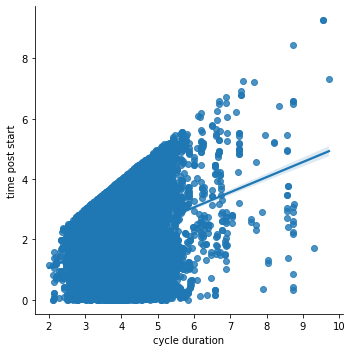

In [97]:
sns.lmplot(data=df_times_all[['time post start','cycle duration']], x='cycle duration',y='time post start')

In [45]:
df_times_all.describe()

,cycle,start cycle,transition ie,stop cycle,inspi duration,expi duration,cycle duration,spindle time,time post start,time vs transition ie,time pre end,norm time
count,22979.000000,22979.000000,22979.000000,22979.000000,22979.000000,22979.000000,22979.000000,22979.000000,22979.000000,22979.000000,22979.000000,22979.000000
mean,469.195135,4245.863505,4247.280482,4249.797100,1.416977,2.516618,3.933595,4247.892505,2.029000,0.612023,1.904594,0.516061
std,324.044388,2377.793573,2377.797771,2377.876208,0.304142,0.558248,0.668045,2377.813068,1.200021,1.193878,1.199694,0.290280
min,0.000000,0.605469,2.574219,4.535156,0.503906,0.757812,2.000000,0.945312,0.000000,-3.441406,0.000000,0.000000
25%,208.000000,2325.691406,2326.753906,2328.839844,1.234375,2.164062,3.546875,2327.144531,1.003906,-0.394531,0.882812,0.261781
50%,422.000000,4250.488281,4251.933594,4254.269531,1.414062,2.453125,3.921875,4251.746094,2.050781,0.667969,1.796875,0.536585
75%,674.000000,6078.511719,6079.832031,6082.738281,1.550781,2.783203,4.246094,6081.388672,2.949219,1.550781,2.835938,0.767550
max,1439.000000,9764.000000,9764.902344,9767.902344,5.871094,8.585938,9.718750,9766.519531,9.261719,8.121094,8.406250,1.000000


In [46]:
def get_timestamps_décalé(df_cycles, spindles_times, patient):
    rows = []

    for cycle in df_cycles.index: # loop only on cycles with spindles found inside
        
        if cycle == df_cycles.index[-1]:
            break

        start = df_cycles.loc[cycle,'expi_time'] # get start time of the cycle
        transition = df_cycles.loc[cycle+1,'inspi_time'] # get i-e time of the cycle
        stop = df_cycles.loc[cycle+1,'expi_time'] # get stop time of the cycle
        duration = stop - start

        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values # keep the spindles of the cycle

        for spindle_time in spindles_of_the_cycle: # loop on spindles of the cycle
            time_post_start = spindle_time - start
            time_vs_transition = spindle_time - transition
            time_pre_end = stop - spindle_time

            norm_time = (spindle_time - start) / duration

            rows.append([patient, cycle, start, duration, spindle_time, time_post_start, time_vs_transition, time_pre_end, norm_time])
    df_times = pd.DataFrame(rows, columns = ['patient','cycle','start cycle', 'cycle duration','spindle time', 'time post start', 'time vs transition ei','time pre end','norm time'])
    return df_times

In [47]:
concat_df_times_décalé = []

for patient in patients:
    df_cycles, spindles_times = load_rsp_spindles(patient)
    concat_df_times_décalé.append(get_timestamps_décalé(df_cycles, spindles_times, patient))
    
df_times_all_décalé = pd.concat(concat_df_times_décalé)

In [48]:
df_times_all_décalé

,patient,cycle,start cycle,cycle duration,spindle time,time post start,time vs transition ei,time pre end,norm time
0,P1,0,16.406250,11.863281,16.878906,0.472656,-10.234375,11.390625,0.039842
1,P1,0,16.406250,11.863281,16.507812,0.101562,-10.605469,11.761719,0.008561
2,P1,1,28.269531,3.019531,29.421875,1.152344,-0.808594,1.867188,0.381630
3,P1,2,31.289062,3.089844,32.152344,0.863281,-1.082031,2.226562,0.279393
4,P1,2,31.289062,3.089844,32.066406,0.777344,-1.167969,2.312500,0.251580
...,...,...,...,...,...,...,...,...,...
2363,P10,753,7060.156250,13.078125,7062.191406,2.035156,-9.863281,11.042969,0.155615
2364,P10,753,7060.156250,13.078125,7072.378906,12.222656,0.324219,0.855469,0.934588
2365,P10,753,7060.156250,13.078125,7062.187500,2.031250,-9.867188,11.046875,0.155317
2366,P10,753,7060.156250,13.078125,7062.187500,2.031250,-9.867188,11.046875,0.155317


In [49]:
df_times_all_décalé.describe()

,cycle,start cycle,cycle duration,spindle time,time post start,time vs transition ei,time pre end,norm time
count,23918.000000,23918.000000,23918.000000,23918.000000,23918.000000,23918.000000,23918.000000,23918.000000
mean,459.112175,4172.978532,29.628598,4187.805117,14.826585,-13.383323,14.802012,0.454631
std,321.876349,2373.827639,145.224067,2362.240807,88.304344,79.543825,79.513916,0.336729
min,0.000000,4.488281,1.925781,4.722656,0.000000,-1158.281250,0.000000,0.000000
25%,194.000000,2196.885742,3.941406,2220.736328,1.031250,-4.838867,1.075195,0.140498
50%,405.000000,4159.455078,5.117188,4162.982422,1.953125,-1.199219,2.609375,0.380858
75%,663.000000,6010.433594,9.943359,6016.813477,3.480469,0.316406,6.256836,0.795856
max,1438.000000,9760.605469,1161.234375,9761.085938,1123.058594,3.949219,1159.402344,1.000000


<AxesSubplot:>

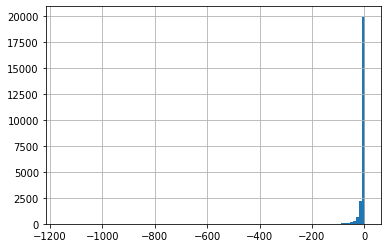

In [50]:
df_times_all_décalé['time vs transition ei'].hist(bins=100)

In [51]:
df_times_all_décalé[df_times_all_décalé['cycle duration'] > 50]

,patient,cycle,start cycle,cycle duration,spindle time,time post start,time vs transition ei,time pre end,norm time
258,P1,98,772.988281,64.570312,773.023438,0.035156,-63.468750,64.535156,0.000544
259,P1,98,772.988281,64.570312,837.007812,64.019531,0.515625,0.550781,0.991470
260,P1,98,772.988281,64.570312,836.804688,63.816406,0.312500,0.753906,0.988324
261,P1,98,772.988281,64.570312,836.695312,63.707031,0.203125,0.863281,0.986630
1142,P1,440,3709.910156,58.277344,3710.460938,0.550781,-56.648438,57.726562,0.009451
...,...,...,...,...,...,...,...,...,...
2081,P10,635,6104.054688,88.179688,6105.117188,1.062500,-85.957031,87.117188,0.012049
2082,P10,635,6104.054688,88.179688,6192.125000,88.070312,1.050781,0.109375,0.998760
2239,P10,698,6587.984375,79.265625,6666.890625,78.906250,0.992188,0.359375,0.995466
2240,P10,698,6587.984375,79.265625,6588.609375,0.625000,-77.289062,78.640625,0.007885


In [52]:
df_times_all

,patient,cycle,start cycle,transition ie,stop cycle,inspi duration,expi duration,cycle duration,spindle time,time post start,time vs transition ie,time pre end,norm time
0,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.878906,1.562500,0.472656,1.082031,0.590842
1,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.507812,1.191406,0.101562,1.453125,0.450517
2,P1,1,27.113281,28.269531,30.230469,1.156250,1.960938,3.117188,29.421875,2.308594,1.152344,0.808594,0.740602
3,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.152344,1.921875,0.863281,1.082031,0.639792
4,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.066406,1.835938,0.777344,1.167969,0.611183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.191406,3.253906,2.035156,0.027344,0.991667
1878,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1879,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1880,P10,754,7072.054688,7073.234375,7075.253906,1.179688,2.019531,3.199219,7072.378906,0.324219,-0.855469,2.875000,0.101343


In [72]:
df_times_all.mean()

/tmp/ipykernel_2528901/3433375342.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_times_all.mean()


cycle                     469.195135
start cycle              4245.863505
transition ie            4247.280482
stop cycle               4249.797100
inspi duration              1.416977
expi duration               2.516618
cycle duration              3.933595
spindle time             4247.892505
time post start             2.029000
time vs transition ie       0.612023
time pre end                1.904594
norm time                   0.516061
dtype: float64

In [53]:
def spindle_speed(df):
    df_patient =  df[(df['patient'] == patient)]
    rows = []
    for c in df_patient['cycle'].unique():
        row = df_patient[df_patient['cycle'] == c]
        rows.append(row[colname].values)
        
    if ax is None:
        fig, ax = plt.subplots()
    ax.eventplot(rows,linelengths=10, linewidth = 2, colors = 'black')
    return ax

In [54]:
df_times_all

,patient,cycle,start cycle,transition ie,stop cycle,inspi duration,expi duration,cycle duration,spindle time,time post start,time vs transition ie,time pre end,norm time
0,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.878906,1.562500,0.472656,1.082031,0.590842
1,P1,0,15.316406,16.406250,17.960938,1.089844,1.554688,2.644531,16.507812,1.191406,0.101562,1.453125,0.450517
2,P1,1,27.113281,28.269531,30.230469,1.156250,1.960938,3.117188,29.421875,2.308594,1.152344,0.808594,0.740602
3,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.152344,1.921875,0.863281,1.082031,0.639792
4,P1,2,30.230469,31.289062,33.234375,1.058594,1.945312,3.003906,32.066406,1.835938,0.777344,1.167969,0.611183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.191406,3.253906,2.035156,0.027344,0.991667
1878,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1879,P10,753,7058.937500,7060.156250,7062.218750,1.218750,2.062500,3.281250,7062.187500,3.250000,2.031250,0.031250,0.990476
1880,P10,754,7072.054688,7073.234375,7075.253906,1.179688,2.019531,3.199219,7072.378906,0.324219,-0.855469,2.875000,0.101343


In [55]:
df_times_all[(df_times_all['patient'] == 'P1') & (df_times_all['cycle'] == 178)]

,patient,cycle,start cycle,transition ie,stop cycle,inspi duration,expi duration,cycle duration,spindle time,time post start,time vs transition ie,time pre end,norm time
455,P1,178,1539.796875,1540.886719,1542.609375,1.089844,1.722656,2.8125,1539.796875,0.000000,-1.089844,2.812500,0.000000
456,P1,178,1539.796875,1540.886719,1542.609375,1.089844,1.722656,2.8125,1540.117188,0.320312,-0.769531,2.492188,0.113889
457,P1,178,1539.796875,1540.886719,1542.609375,1.089844,1.722656,2.8125,1540.296875,0.500000,-0.589844,2.312500,0.177778
458,P1,178,1539.796875,1540.886719,1542.609375,1.089844,1.722656,2.8125,1540.296875,0.500000,-0.589844,2.312500,0.177778
459,P1,178,1539.796875,1540.886719,1542.609375,1.089844,1.722656,2.8125,1542.519531,2.722656,1.632812,0.089844,0.968056


In [56]:
count = []
for i, row in df_times_all.iterrows():
    if row['spindle time'] < row['transition ie']:
        count.append('i')
    else:
        count.append('e')

In [57]:
pd.Series(count).value_counts()

e    15129
i     7850
dtype: int64

In [59]:
def speed_spindles(step, patient, spindles_times, df_cycles, stage='N2', return_normal=True):

    rows = []

    for cycle in df_cycles.index: # loop only on cycles with spindles found inside
        
        start = df_cycles.loc[cycle,'inspi_time'] # get start time of the cycle
        stop = df_cycles.loc[cycle,'end_time'] # get stop time of the cycle

        phases_timings = np.arange(start, stop, step) # slice the cycle time in n equal phase time points
        
        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values # keep the spindles of the cycle
        
        for phase_bin, phase_start in enumerate(phases_timings): # loop on phases start times and attribute bin value to the phase
            if phase_start == phases_timings[-1]: # trick to stop looping if phase start == last phase timing
                break 
            else:
                phase_stop = phases_timings[phase_bin + 1] # stop time of this phase bin = next phase timing after the start phase timing of the list
                nspindles_in_time_slice = spindles_times[(spindles_times >= phase_start) & (spindles_times <= phase_stop)].shape[0]
                rows.append([cycle , start , stop , phase_bin, phase_start, phase_stop, nspindles_in_time_slice, nspindles_in_time_slice/step])
#     if not return_normal: # return raw counts of spindles by bins
#         phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
#         phase_count = phase_count.to_frame().T
#     else: # return normalized counts of spindles by bins (each bin value = bin value / sum of all bin values) = default mode
#         phase_count = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
#         phase_count = phase_count.to_frame().T
#         mi = gh.Modulation_Index(phase_count.values)
#         phase_count.insert(0 , 'mi', mi)

#     phase_count.insert(0 , 'patient', patient)

    return pd.DataFrame(rows, columns = ['cycle','start','stop','time bin','bin start','bin stop','nspindles','speed'])

In [60]:
def get_patient_time_histogram(patient, step, stage='N2'):
    df_cycles, spindles_times = load_rsp_spindles(patient, stage)
    count = speed_spindles(step=step, patient=patient, spindles_times=spindles_times, df_cycles=df_cycles, stage=stage)
    # count.insert(1 , 'stage' , stage)
    return count

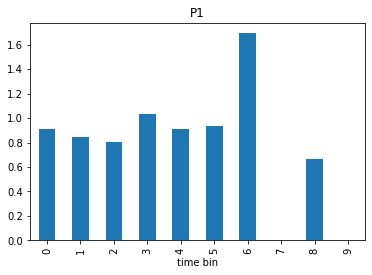

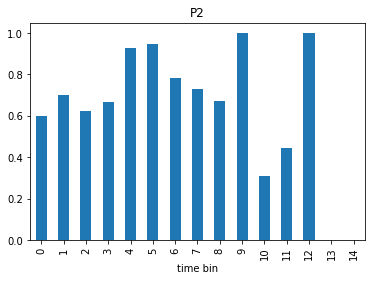

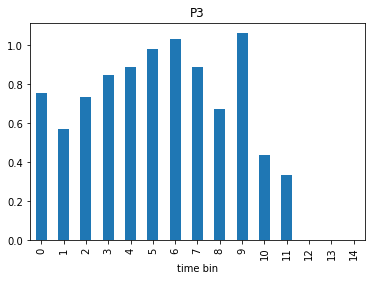

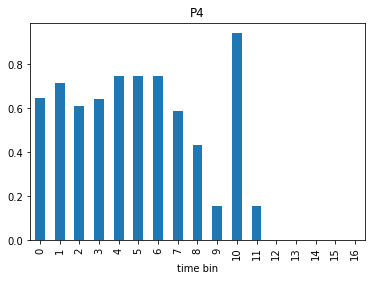

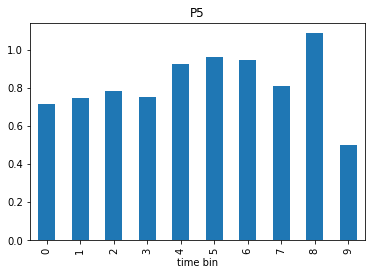

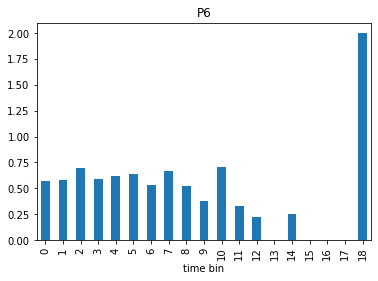

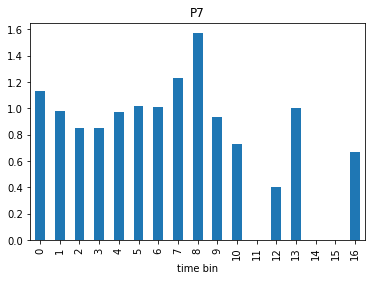

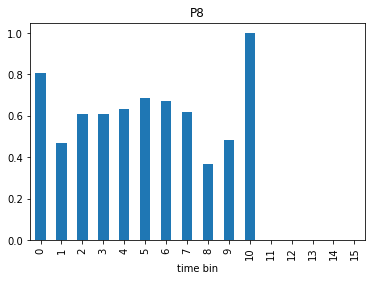

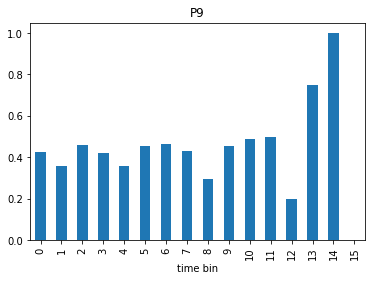

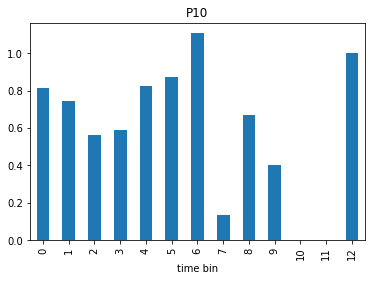

In [73]:
for patient in patients:
    test = get_patient_time_histogram(patient, 0.5)
    test.groupby('time bin').mean()['speed'].plot.bar()
    plt.title(patient)
    plt.show()

In [74]:
count = get_patient_time_histogram('P1', step = 0.1 )

In [75]:
test = get_patient_time_histogram('P3', 0.5)

In [70]:
test

,cycle,start,stop,time bin,bin start,bin stop,nspindles,speed
0,0,9.449219,13.050781,0,9.449219,9.949219,0,0.0
1,0,9.449219,13.050781,1,9.949219,10.449219,0,0.0
2,0,9.449219,13.050781,2,10.449219,10.949219,2,4.0
3,0,9.449219,13.050781,3,10.949219,11.449219,0,0.0
4,0,9.449219,13.050781,4,11.449219,11.949219,0,0.0
...,...,...,...,...,...,...,...,...
7472,968,8830.519531,8835.261719,4,8832.519531,8833.019531,0,0.0
7473,968,8830.519531,8835.261719,5,8833.019531,8833.519531,0,0.0
7474,968,8830.519531,8835.261719,6,8833.519531,8834.019531,5,10.0
7475,968,8830.519531,8835.261719,7,8834.019531,8834.519531,1,2.0


<AxesSubplot:xlabel='time bin'>

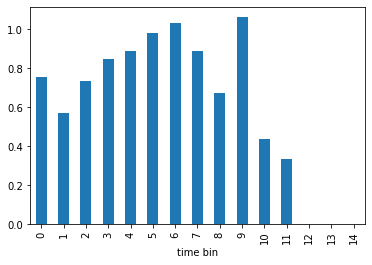

In [71]:
test.groupby('time bin').mean()['speed'].plot.bar()